# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [1]:
import sys
import gymnasium as gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

import random

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [2]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [3]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

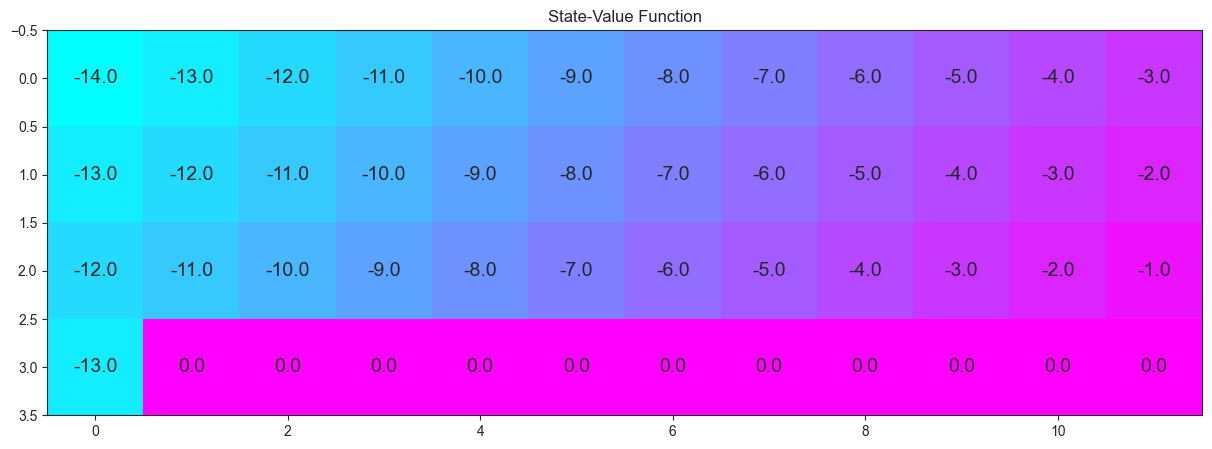

In [4]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [5]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    #print ("state: ", state)
    #print ("action: ", action)
    
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value
    return new_value

def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))

In [6]:
def sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                             # initialize score
        state = env.reset()[0]                                # start episode
        #print("reset state: ", state)
        #pdb.set_trace()
        
        eps = 1.0 / i_episode                                 # set value of epsilon
        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        
        while True:
            next_state, reward, terminated, truncated , info = env.step(action) # take action A, observe R, S'
            done = truncated or terminated 
            score += reward                                   # add reward to agent's score
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps) # epsilon-greedy action
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state     # S <- S'
                action = next_action   # A <- A'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                tmp_scores.append(score)    # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

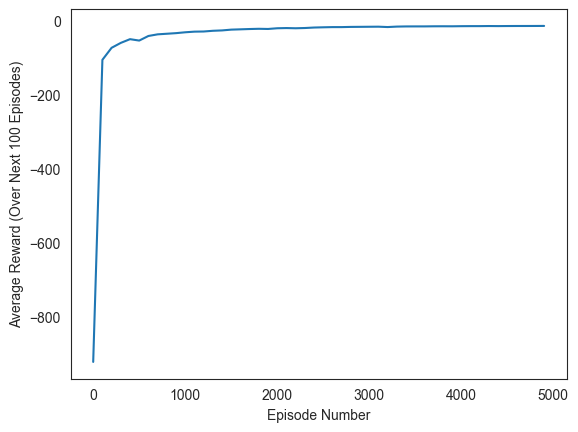

Best Average Reward over 100 Episodes:  -15.54


**<span style="color: red;">PLEASE TRY AGAIN</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  2  1  2  1  1  1  1  2  2]
 [ 0  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


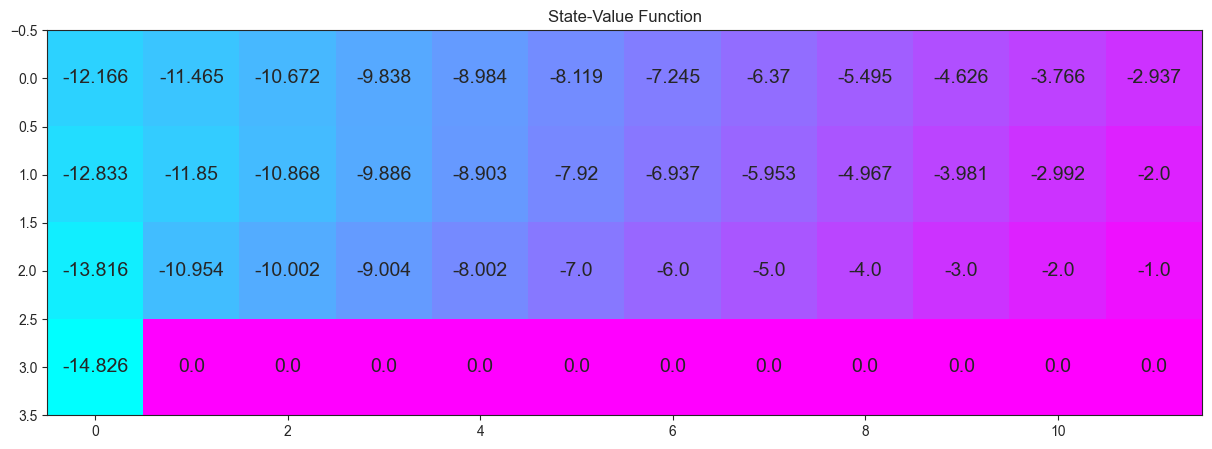

defaultdict(<function __main__.sarsa.<locals>.<lambda>()>,
            {36: array([ -14.825584  , -157.91810886,  -51.26875765,  -60.40084441]),
             24: array([-13.81586518, -20.00616161, -48.42869439, -14.03688009]),
             12: array([-12.83555759, -12.83329324, -12.84776655, -12.85018818]),
             0: array([-12.17209427, -12.16559642, -12.17182066, -12.17530486]),
             13: array([-11.85060669, -11.84994205, -11.85034898, -11.86371951]),
             14: array([-10.87227651, -10.86773001, -10.86887384, -10.86973559]),
             1: array([-11.4677755 , -11.46521915, -11.474316  , -11.46795199]),
             2: array([-10.68275269, -10.67155781, -10.67297713, -10.67259145]),
             15: array([-9.88585509, -9.88567885, -9.8855731 , -9.90375783]),
             16: array([-8.90689099, -8.90328229, -8.90344641, -8.92156933]),
             4: array([-8.99857703, -8.98414328, -8.98976991, -8.98928075]),
             5: array([-8.12090317, -8.11854345, -8

In [11]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)


In [22]:
sorted(Q_sarsa.items())

[(0, array([-12.17209427, -12.16559642, -12.17182066, -12.17530486])),
 (1, array([-11.4677755 , -11.46521915, -11.474316  , -11.46795199])),
 (2, array([-10.68275269, -10.67155781, -10.67297713, -10.67259145])),
 (3, array([-9.84955547, -9.83798647, -9.83991964, -9.84208602])),
 (4, array([-8.99857703, -8.98414328, -8.98976991, -8.98928075])),
 (5, array([-8.12090317, -8.11854345, -8.12421276, -8.12834841])),
 (6, array([-7.25095358, -7.24549507, -7.24946781, -7.25613839])),
 (7, array([-6.37745887, -6.36974961, -6.370909  , -6.37751336])),
 (8, array([-5.50627413, -5.49528512, -5.49574707, -5.49964455])),
 (9, array([-4.63171135, -4.62583918, -4.62627747, -4.63092526])),
 (10, array([-3.77566047, -3.76564568, -3.76745643, -3.78162475])),
 (11, array([-2.9375324 , -2.95024457, -2.93674389, -2.95140625])),
 (12, array([-12.83555759, -12.83329324, -12.84776655, -12.85018818])),
 (13, array([-11.85060669, -11.84994205, -11.85034898, -11.86371951])),
 (14, array([-10.87227651, -10.8677300

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [23]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0  # value of next state 
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value 
    return new_value

In [26]:
def q_learning(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    """Q-Learning - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): learning rate
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0                                              # initialize score
        state = env.reset()[0]                                 # start episode
        eps = 1.0 / i_episode                                  # set value of epsilon
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, terminated, truncated , info = env.step(action) # take action A, observe R, S'
            done = truncated or terminated 
            score += reward                                    # add reward to agent's score
            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                                 state, action, reward, next_state)        
            state = next_state                                 # S <- S'
            if done:
                tmp_scores.append(score)                       # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

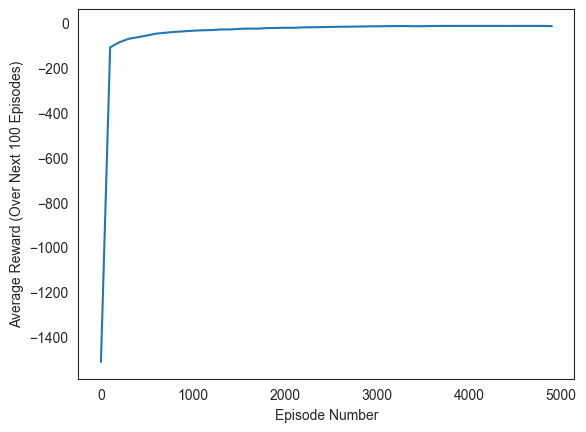

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  1  0  2  0  1  1  2  1  2  2  2]
 [ 1  1  1  1  1  1  2  1  0  1  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


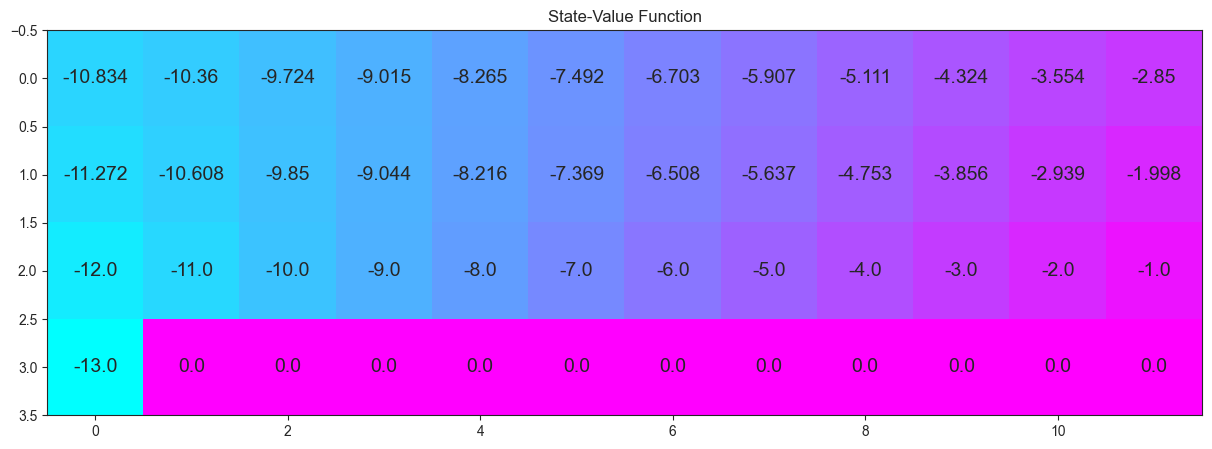

In [27]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])


In [31]:
sorted(Q_sarsamax.items())

[(0, array([-10.83437543, -10.83826956, -10.84119972, -10.84129505])),
 (1, array([-10.36572347, -10.36040247, -10.36889587, -10.36889917])),
 (2, array([-9.72370538, -9.72483177, -9.73245294, -9.733683  ])),
 (3, array([-9.02307052, -9.01573454, -9.01453539, -9.02824952])),
 (4, array([-8.26487727, -8.26627806, -8.26921154, -8.27308903])),
 (5, array([-7.49678641, -7.49224795, -7.49466845, -7.50092729])),
 (6, array([-6.70826163, -6.70294095, -6.70853917, -6.71526503])),
 (7, array([-5.90990477, -5.90798908, -5.90680731, -5.91418851])),
 (8, array([-5.11708489, -5.11139485, -5.11691191, -5.11158732])),
 (9, array([-4.32876593, -4.32463118, -4.32372614, -4.33005677])),
 (10, array([-3.55609278, -3.55550145, -3.55438265, -3.5653698 ])),
 (11, array([-2.84989918, -2.84990106, -2.84989296, -2.85033801])),
 (12, array([-11.27435215, -11.2719955 , -11.28106468, -11.27371871])),
 (13, array([-10.61488127, -10.6077908 , -10.61137629, -10.61967096])),
 (14, array([-9.85406006, -9.85005529, -9.

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [28]:
def update_Q_expsarsa(alpha, gamma, nA, eps, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]         # estimate in Q-table (for current state, action pair)
    policy_s = np.ones(nA) * eps / nA  # current policy (for next state S')
    policy_s[np.argmax(Q[next_state])] = 1 - eps + (eps / nA) # greedy action
    Qsa_next = np.dot(Q[next_state], policy_s)         # get value of state at next time step
    target = reward + (gamma * Qsa_next)               # construct target
    new_value = current + (alpha * (target - current)) # get updated value 
    return new_value

In [29]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    """Expected SARSA - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): step-size parameters for the update step
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        score = 0             # initialize score
        state = env.reset()[0]   # start episode
        eps = 0.005           # set value of epsilon
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, terminated, truncated , info = env.step(action) # take action A, observe R, S'
            done = truncated or terminated 
            score += reward                                    # add reward to agent's score
            # update Q
            Q[state][action] = update_Q_expsarsa(alpha, gamma, nA, eps, Q, \
                                                 state, action, reward, next_state)        
            state = next_state              # S <- S'
            if done:
                tmp_scores.append(score)    # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 10000/10000

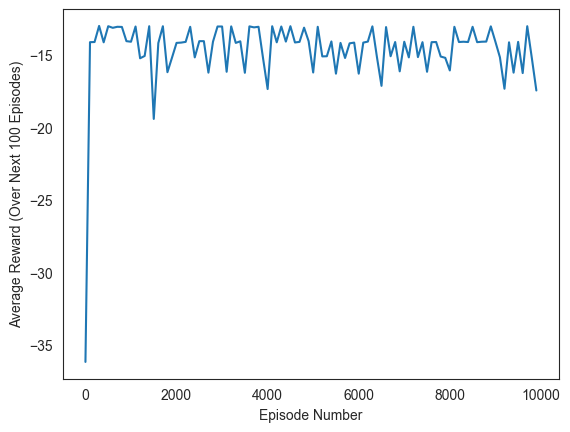

Best Average Reward over 100 Episodes:  -13.02


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  0  1  2  2  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


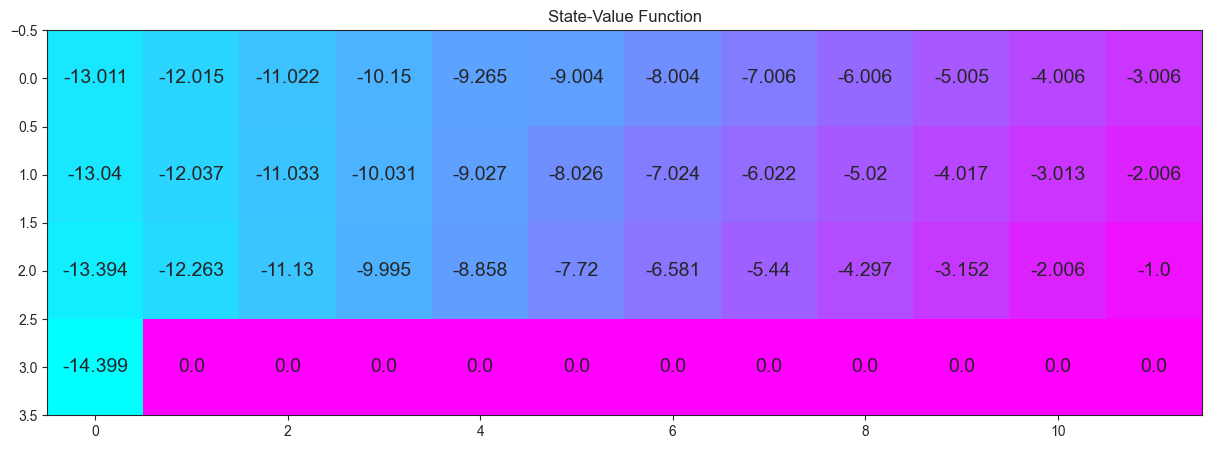

In [30]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 10000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])

In [32]:
sorted(Q_expsarsa.items())

[(0, array([-14.00436338, -13.01108491, -14.0089172 , -13.03894303])),
 (1, array([-12.01500958, -12.02143069, -12.28310129, -13.03894303])),
 (2, array([-12.00944903, -11.0219216 , -11.16496067, -11.0337359 ])),
 (3, array([-11.01689376, -10.15590026, -10.14966894, -12.00743977])),
 (4, array([-10.01802168, -10.00376129,  -9.2647016 , -11.00357809])),
 (5, array([-9.0058064 , -9.00416989, -9.01346434, -9.00747384])),
 (6, array([-8.00936001, -8.00382116, -8.01248193, -8.27595813])),
 (7, array([-7.00756897, -7.00646872, -7.01012719, -7.00774697])),
 (8, array([-7.00380362, -6.00628196, -6.00789797, -7.00631579])),
 (9, array([-6.00396105, -5.00503228, -5.00568737, -5.00519765])),
 (10, array([-5.00252937, -4.00641817, -4.01296321, -5.00395599])),
 (11, array([-4.00127695, -3.00625338, -3.00642544, -5.00535814])),
 (12, array([-14.00436338, -13.040114  , -13.13106329, -13.04476058])),
 (13, array([-12.74402654, -12.03667853, -12.08378876, -14.03060075])),
 (14, array([-12.0037447 , -11